In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score, confusion_matrix
from sklearn.preprocessing import label_binarize
import pickle
from MVDD.MVDD import MVDD
import MVDD.MVDD_Generator as mvGen

%matplotlib inline

plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [2]:
#HELPER CODE

#Validation Method
def performValidation(model, data, realScores, aucName):
    #MVDD Accuracy
    print("\n*****MVDD Validation*****")
    y_pred = model.predictScoreSet(data)
    y_test = realScores
    
    FP = confusion_matrix(y_test,y_pred).sum(axis=0) - np.diag(confusion_matrix(y_test,y_pred))
    FN = confusion_matrix(y_test,y_pred).sum(axis=1) - np.diag(confusion_matrix(y_test,y_pred))
    TP = np.diag(confusion_matrix(y_test,y_pred))
    TN = confusion_matrix(y_test,y_pred).sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    TPR = TPR[~np.isnan(TPR)]
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    TNR = TNR[~np.isnan(TNR)]
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    PPV = PPV[~np.isnan(PPV)]
    # Negative predictive value
    NPV = TN/(TN+FN)
    NPV = NPV[~np.isnan(NPV)]
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    FPR = FPR[~np.isnan(FPR)]
    # False negative rate
    FNR = FN/(TP+FN)
    FNR = FNR[~np.isnan(FNR)]
    # False discovery rate
    FDR = FP/(TP+FP)
    FDR = FDR[~np.isnan(FDR)]

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    #ROC AUC Score
    y_score = label_binarize(y_pred, classes=[1,2,3,4,5])
    y_test = label_binarize(realScores, classes=[1,2,3,4,5])
    fpr, tpr, roc_auc = mvGen.getClassROC(y_test,y_score)
    
    mvGen.getAverageROCGraph(fpr, tpr, roc_auc, aucName)
    
    auc = np.array(list(roc_auc.values()))
    auc = auc[~np.isnan(auc)]
    
    print("Sensitivity (TPR): %0.3f(±%0.3f)" % (np.mean(TPR), np.std(TPR) * 2))
    print("Specificity (TNR): %0.3f(±%0.3f)" % (np.mean(TNR), np.std(TNR) * 2))
    print("Precision (PPV): %0.3f(±%0.3f)" % (np.mean(PPV), np.std(PPV) * 2))
    print("Negative Predictive Value (NPV): %0.3f(±%0.3f)" % (np.mean(NPV), np.std(NPV) * 2))
    print("FPR: %0.3f(±%0.3f)" % (np.mean(FPR), np.std(FPR) * 2))
    print("FNR: %0.3f(±%0.3f)" % (np.mean(FNR), np.std(FNR) * 2))
    print("Accuracy: %0.3f(±%0.3f)" % (np.mean(ACC), np.std(ACC) * 2))
    print("Averaged AUC: %0.3f(±%0.3f)" % (np.mean(auc), np.std(auc) * 2))


# Hemodynamic Model Validation

## Label = Death
Note: validation sets only have death labels to validate for hemo

### Cardiogenic Shock

In [3]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/Hemo_Death')


*****MVDD Validation*****


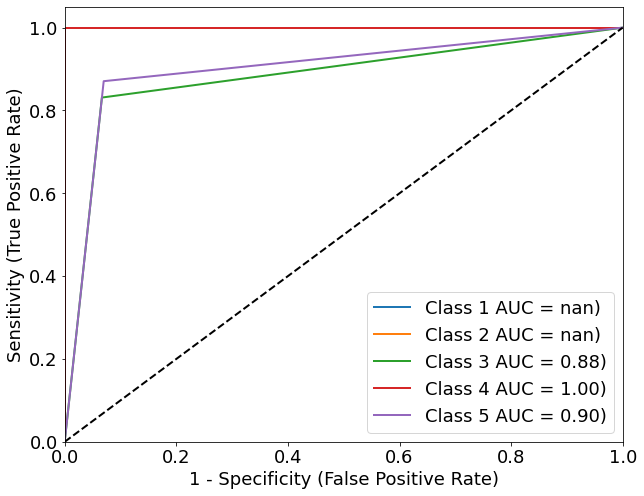

Sensitivity (TPR): 0.901(±0.144)
Specificity (TNR): 0.954(±0.064)
Precision (PPV): 0.899(±0.156)
Negative Predictive Value (NPV): 0.954(±0.067)
FPR: 0.046(±0.064)
FNR: 0.099(±0.144)
Accuracy: 0.938(±0.087)
Averaged AUC: 0.928(±0.104)


In [4]:
hemoCohort = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_Hemo.csv", sep=",", index_col='ID')
deathLabels = hemoCohort['ScoreDeath']

hemo = hemoCohort.drop('ScoreDeath', axis=1)
hemo = hemo.drop('Score', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=hemo, realScores=deathLabels, aucName='HemoCardShock')

### Serial Cardiac

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/Hemo_Death')

In [ ]:
hemoCohort = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_Hemo.csv", sep=",", index_col='ID')
deathLabels = hemoCohort['ScoreDeath']

hemo = hemoCohort.drop('ScoreDeath', axis=1)
hemo = hemo.drop('Score', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=hemo, realScores=deathLabels, aucName='HemoSerialCardiac')

# All Data Model Validation

## Label = All Outcomes
Note: only HF-Action has all outcome label

### HF-ACTION All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_AllOutcomes')

In [ ]:
guideAllData = pd.read_csv("Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['Score']

allD = allD.drop('Score', axis=1)
allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataHFaction')

## Label = Death
Note: All Validation Datasets have the death label

### Cardiogenic Shock All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')

In [ ]:
allDataCohort = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AllData.csv", sep=",", index_col='ID')
deathLabels = allDataCohort['ScoreDeath']

ad = allDataCohort.drop('ScoreDeath', axis=1)
ad = ad.drop('Score', axis=1)
ad = ad.drop('ScoreRehosp', axis=1)
ad = ad.drop('ScoreReadmission', axis=1)
ad = ad.replace(np.inf, 0)
ad = ad.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=ad, realScores=deathLabels, aucName='AllDataCardShock')

### Serial Cardiac All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')

In [ ]:
allDataCohort = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_AllData.csv", sep=",", index_col='ID')
deathLabels = allDataCohort['ScoreDeath']

ad = allDataCohort.drop('ScoreDeath', axis=1)
ad = ad.drop('Score', axis=1)
ad = ad.drop('ScoreRehosp', axis=1)
ad = ad.drop('ScoreReadmission', axis=1)
ad = ad.replace(np.inf, 0)
ad = ad.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=ad, realScores=deathLabels, aucName='AllDataSerialCardiac')

### HF-ACTION All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')

In [ ]:
guideAllData = pd.read_csv("Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AllData.csv", sep=",", index_col='ID')
deathLabels = guideAllData['ScoreDeath']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=deathLabels, aucName='AllDataHFaction')

### BEST All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')

In [ ]:
guideAllData = pd.read_csv("Data Validation/BEST/Preprocessed Data/BEST_AllData.csv", sep=",", index_col='ID')
deathLabels = guideAllData['ScoreDeath']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=deathLabels, aucName='AllDataBest')

### GUIDE-IT All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')

In [ ]:
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv", sep=",", index_col='ID')
deathLabels = guideAllData['ScoreDeath']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=deathLabels, aucName='AllDataGuideIt')

## Label = Rehospitalization
Note: Only HF-ACTION, BEST and GUIDE-IT have rehosp

### HF-ACTION All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Rehosp')

In [ ]:
guideAllData = pd.read_csv("Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['ScoreRehosp']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataHFaction')

### BEST All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Rehosp')

In [ ]:
guideAllData = pd.read_csv("Data Validation/BEST/Preprocessed Data/BEST_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['ScoreRehosp']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataBest')

### GUIDE-IT All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Rehosp')

In [ ]:
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['ScoreRehosp']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataGuideIt')

## Label = Readmission
Note: only HF-ACTION has readm

### HF-ACTION All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Readmission')

In [ ]:
guideAllData = pd.read_csv("Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['ScoreReadmission']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataHFaction')